In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [3]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [4]:
image = Image.open('images/frame_0.jpg')
image = np.array(image.convert("RGB"))

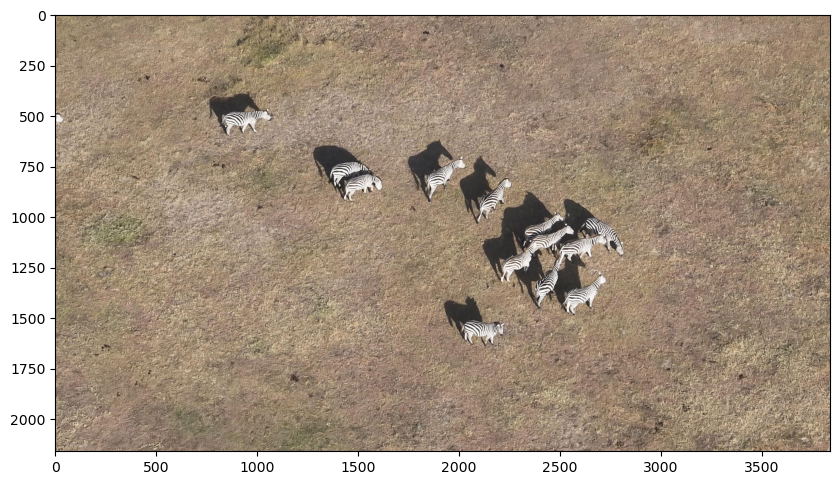

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [19]:
import sys
sys.path.append('/home/anansupercuteeeee/Music/tow/segment-anything-tool')

In [2]:
from sam2.build_sam import build_sam2

In [7]:
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
if not os.path.exists(sam2_checkpoint):
    raise FileNotFoundError(f"Checkpoint file not found: {sam2_checkpoint}")

In [25]:
import os

# In thư mục làm việc hiện tại
print("Thư mục hiện tại:", os.getcwd())

# Thay đổi thư mục làm việc sang thư mục gốc của dự án
os.chdir("/home/anansupercuteeeee/Music/tow/segment-anything-tool/notebooks")

# In thư mục làm việc hiện tại
print("Thư mục hiện tại:", os.getcwd())

Thư mục hiện tại: /home/anansupercuteeeee/Music/tow/segment-anything-tool
Thư mục hiện tại: /home/anansupercuteeeee/Music/tow/segment-anything-tool/notebooks


In [3]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

NameError: name 'device' is not defined

In [9]:
predictor.set_image(image)

In [1]:
file_path = 'images/frame_0.json'
file_name = file_path.split('/')[-1]
print(file_name)  # Kết quả sẽ là 'frame_0.json'

file_path = 'images/frame_0.jpg'
file_name = file_path.split('/')[-1]
print(file_name)  # Kết quả sẽ là 'frame_0.jpg'

frame_0.json
frame_0.jpg


In [10]:
import json

# Path to your JSON file
file_path = 'images/frame_0.json'

# Open the JSON file and load its contents into a variable
with open(file_path, 'r') as file:
    data = json.load(file)

# Now `data` contains the contents of the JSON file
print(data)  # Print the data to verify

bbox_list = data['shapes']
bbox = []
for box in bbox_list:
    point = np.array(box['points'])
    pt = np.concat((point[0], point[2]))
    print(pt)
    bbox.append(pt)
pt
# bbox = [shape[]]

{'version': '2.5.4', 'flags': {}, 'shapes': [{'kie_linking': [], 'label': 'zebra', 'score': 0.6548040509223938, 'points': [[823.0, 462.0], [1072.0, 462.0], [1072.0, 597.0], [823.0, 597.0]], 'group_id': 0, 'description': None, 'difficult': False, 'shape_type': 'rectangle', 'flags': None, 'attributes': {}}, {'kie_linking': [], 'label': 'zebra', 'score': 0.6104981899261475, 'points': [[2002.0, 1509.0], [2226.0, 1509.0], [2226.0, 1641.0], [2002.0, 1641.0]], 'group_id': 1, 'description': None, 'difficult': False, 'shape_type': 'rectangle', 'flags': None, 'attributes': {}}, {'kie_linking': [], 'label': 'zebra', 'score': 0.6329305171966553, 'points': [[1826.0, 702.0], [2034.0, 702.0], [2034.0, 926.0], [1826.0, 926.0]], 'group_id': 2, 'description': None, 'difficult': False, 'shape_type': 'rectangle', 'flags': None, 'attributes': {}}, {'kie_linking': [], 'label': 'zebra', 'score': 0.5978159308433533, 'points': [[2086.0, 802.0], [2262.0, 802.0], [2262.0, 1028.0], [2086.0, 1028.0]], 'group_id': 

array([  0.        , 458.04878049,  58.53658537, 553.17073171])

In [11]:
input_boxes = np.array(bbox)

In [12]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

In [13]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

(14, 1, 2160, 3840)

In [1]:
from sam2.sam2_image_predictor import ImageManualPredictor

In [4]:
import os

source = "images/frame_0.jpg"
base_path = os.path.splitext(source)[0]
file_name = source.split('/')[-1]
json_path = base_path + '.json'
print(base_path, file_name, json_path)

images/frame_0 frame_0.jpg images/frame_0.json


In [2]:
result = ImageManualPredictor().predict(
    "/home/anansupercuteeeee/Music/tow/DJI_20230719145816_0003_V_video1/label",
    
    "../checkpoints/sam2.1_hiera_large.pt",
    "configs/sam2.1/sam2.1_hiera_l.yaml",
    
)
# sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
# model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/sam2.1_hiera_large.pt'

In [3]:
import json
import numpy as np

def convert_to_native_types(obj):
    if isinstance(obj, (np.int64, np.int32, np.float64, np.float32)):
        return int(obj) if isinstance(obj, (np.int64, np.int32)) else float(obj)
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: convert_to_native_types(value) for key, value in obj.items()}
    else:
        return obj

def convert(group_id, masks):
    shapes = []

    for i in range(masks.shape[0]):
        # Example binary mask (replace this with your actual mask)
        binary_mask = np.squeeze(masks[i])

        # Step 1: Find the coordinates of all pixels with value 1
        coordinates = np.argwhere(binary_mask == 1)

        # Step 2: Convert to the required format
        segmentation = coordinates[:, [1, 0]].tolist()  # Swap columns to get [x, y] format

        # Create a new dictionary for each mask
        shape_format = {
            "label": "zebra",
            "score": None,
            "points": segmentation,  # Assign segmentation data to "points"
            "group_id": group_id[i],  # Assign group_id
            "description": "",
            "difficult": False,
            "shape_type": "polygon",
            "flags": {},
            "attributes": {},
            "kie_linking": []
        }

        # Convert NumPy types to native Python types
        shape_format = convert_to_native_types(shape_format)

        # Append the shape to the list
        shapes.append(shape_format)

    return shapes

# Example usage
if __name__ == "__main__":
    # Example masks (replace with your actual data)
    masks = np.array([
        [
            [0, 0, 0, 0],
            [0, 1, 1, 0],
            [0, 1, 1, 0],
            [0, 0, 0, 0]
        ],
        [
            [0, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 1, 1, 0],
            [0, 0, 0, 0]
        ]
    ])

    # Example group_id (replace with your actual data)
    group_id = [8, 9]

    # Convert masks to the required format
    shapes = convert(group_id, masks)

    # Save to JSON
    output_folder = "output"
    output_file = f"{output_folder}/output.json"

    # Create the folder if it doesn't exist
    from pathlib import Path
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    # Write to a JSON file
    with open(output_file, "w") as json_file:
        json.dump(shapes, json_file, indent=4)  # indent=4 for pretty-printing

    print(f"Data written to {output_file}")

Data written to output/output.json


In [3]:
print(result)

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. 

In [5]:
result.shape

(14, 1, 2160, 3840)

In [19]:
result[0].shape

(1, 2160, 3840)

In [21]:
import cv2
import numpy as np

# Example binary mask (replace this with your actual mask)
binary_mask = np.squeeze(result[0])  # Remove singleton dimensions

# Step 1: Convert the mask to uint8
# If the mask contains values in the range [0, 1], scale it to [0, 255]
binary_mask = (binary_mask * 255).astype(np.uint8)

# Step 2: Threshold the mask (if necessary)
# Ensure the mask is binary (values 0 or 255)
_, binary_mask = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)

# Step 3: Find contours
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Convert contours to the required format
segmentation = []
for contour in contours:
    # Reshape contour to [N, 2] where N is the number of points
    contour = contour.squeeze().tolist()
    segmentation.append(contour)

# Output
print("segmentation:", segmentation)

segmentation: [[[1056, 465], [1055, 466], [1053, 466], [1052, 467], [1049, 467], [1048, 468], [1047, 468], [1046, 469], [1045, 469], [1044, 470], [1041, 470], [1040, 471], [1035, 471], [1034, 472], [1028, 472], [1027, 473], [1026, 472], [1007, 472], [1006, 473], [999, 473], [998, 474], [989, 474], [988, 475], [982, 475], [981, 476], [978, 476], [977, 477], [974, 477], [973, 478], [969, 478], [968, 479], [957, 479], [956, 480], [942, 480], [941, 479], [936, 479], [935, 480], [923, 480], [922, 481], [907, 481], [906, 480], [893, 480], [892, 479], [891, 480], [880, 480], [879, 481], [874, 481], [873, 482], [871, 482], [870, 483], [867, 483], [866, 484], [864, 484], [863, 485], [861, 485], [860, 486], [859, 486], [858, 487], [857, 487], [856, 488], [855, 488], [854, 489], [852, 489], [851, 490], [850, 490], [849, 491], [848, 491], [847, 492], [845, 492], [844, 493], [841, 493], [840, 494], [839, 494], [838, 495], [837, 495], [836, 496], [835, 496], [832, 499], [832, 500], [831, 501], [831,

In [29]:
result.shape[0]

14

In [24]:
import numpy as np

# Example binary mask (replace this with your actual mask)
binary_mask = np.squeeze(result[0])

# Step 1: Find the coordinates of all pixels with value 1
coordinates = np.argwhere(binary_mask == 1)

# Step 2: Convert to the required format
segmentation = coordinates[:, [1, 0]].tolist()  # Swap columns to get [x, y] format

# Output
print("segmentation:", segmentation)

segmentation: [[1056, 465], [1057, 465], [1053, 466], [1054, 466], [1055, 466], [1056, 466], [1057, 466], [1058, 466], [1059, 466], [1049, 467], [1050, 467], [1051, 467], [1052, 467], [1053, 467], [1054, 467], [1055, 467], [1056, 467], [1057, 467], [1058, 467], [1059, 467], [1060, 467], [1047, 468], [1048, 468], [1049, 468], [1050, 468], [1051, 468], [1052, 468], [1053, 468], [1054, 468], [1055, 468], [1056, 468], [1057, 468], [1058, 468], [1059, 468], [1060, 468], [1045, 469], [1046, 469], [1047, 469], [1048, 469], [1049, 469], [1050, 469], [1051, 469], [1052, 469], [1053, 469], [1054, 469], [1055, 469], [1056, 469], [1057, 469], [1058, 469], [1059, 469], [1060, 469], [1041, 470], [1042, 470], [1043, 470], [1044, 470], [1045, 470], [1046, 470], [1047, 470], [1048, 470], [1049, 470], [1050, 470], [1051, 470], [1052, 470], [1053, 470], [1054, 470], [1055, 470], [1056, 470], [1057, 470], [1058, 470], [1059, 470], [1060, 470], [1035, 471], [1036, 471], [1037, 471], [1038, 471], [1039, 471

In [ ]:
a = {
    "version": "2.5.4",
    "flags": {}, 
    "shapes": [

    ]
}
b = {
    "label": "zebra",
    "score": null,
    "points":,
    "group_id": 8,
      "description": "",
      "difficult": false,
      "shape_type": "polygon",
      "flags": {},
      "attributes": {},
      "kie_linking": []
}

In [ ]:
import json

# Define the dictionary
b = {
    "label": "zebra",
    "score": None,
    "points": [],  # Example coordinates
    "group_id": None,  # Explicitly set to None
    "description": "",
    "difficult": False,
    "shape_type": "polygon",
    "flags": {},
    "attributes": {},
    "kie_linking": []
}
b["points"] = segmentation

# Write to a JSON file
with open("output/output.json", "w") as json_file:
    json.dump(b, json_file, indent=4)  # indent=4 for pretty-printing

print("Data written to output.json")

Data written to output.json


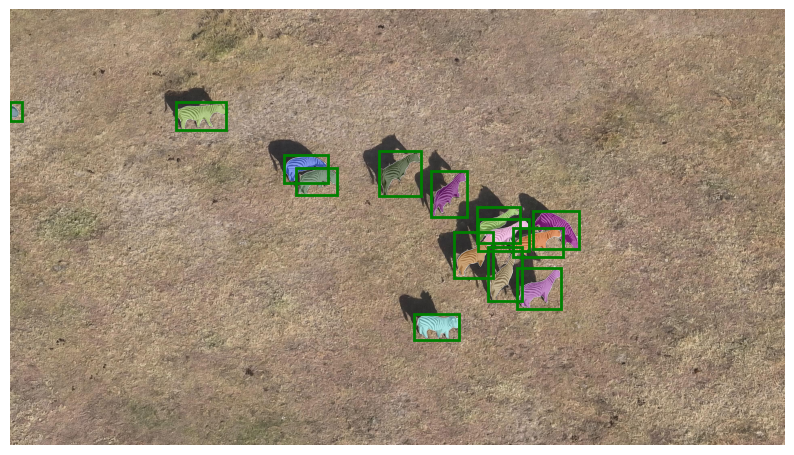

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()